# Predicting Bank Churn 

The dataset used in this notebook represents bank churn data from a bank in Europe. “Churn” is a term that refers to customers leaving and taking their business elsewhere. 

The modeling objective is to build and test models that will use banking data to predict whether a customer will churn. If a customer churns, it means they left the bank and took their business elsewhere. If we can predict customers who are likely to churn, we can take measures to retain them before they do. These measures could be promotions, discounts, or other incentives to boost customer satisfaction and, therefore, retention.

Note that many societies now understand that gender is not binary and there is fluidity in the category across people and time, so creating categories that allow for that leads to more accurate data collection processes.

Models Used:
- Decision Tree
- Tuned Decision Tree
- Cross Validated Random Forest
- Random Forest with Separate Validation Set
- XGBoost

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

import pickle

url = 'https://raw.githubusercontent.com/adacert/churn/main/Churn_Modelling.csv'
df_original = pd.read_csv(url)

In [2]:
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
# Check class balance
df_original['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

The class of the target variable is split roughly 80/20. In other words, ~20% of the people in this dataset churned. This is an unbalanced dataset, but it's not extreme.

In [5]:
# Calculate average balance of customers who churned
avg_churned_bal = df_original[df_original['Exited']==1]['Balance'].mean()
avg_churned_bal

91108.53933726068

This shows that the customers who churned each took with them €91,108.54, on average, which is a lot of money. This represents the average cost of the model predicting a false negative. 

Since correctly identifying customers who will churn is potentially very valuable, we could select recall as our most important metric. This might be a perfectly valid approach, depending on the specifics of the campaign. But this could also be problematic. After all, if we select a model based solely on recall, we could select a very biased model that predicts everyone to churn, but then 8,000 people would be given incentives needlessly.  

Since we don't know the exact cost of predicting a false negative, we'll assume that a metric that balances precision and recall is best. The metric that helps us achieve this balance is _F1 score_, which is defined as the harmonic mean of precision and recall. 

$${F_{1}} = 2 \cdot \frac{precision \cdot  recall}{precision + recall}$$  
</br>

## Feature Selection
The first column is called `RowNumber`, and it just enumerates the rows. This feature should be dropped because row number shouldn't have any correlation with whether or not a customer churned. The same is true for `CustomerID`, which appears to be a number assigned to the customer for administrative purposes, and `Surname`, which is the customer's last name. Since these cannot be expected to have any influence over the target variable, we can remove them from the modeling dataset.

Finally, for ethical reasons, we should remove the `Gender` column. The reason for doing this is that we don't want our model-making predictions (and therefore, offering promotions/financial incentives) based on a person's gender.

In [6]:
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], axis=1)
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


## Feature Extraction
Suppose the bank had a computer glitch that caused many credit card transactions to be mistakenly declined in October. It would be reasonable to suspect that people who experienced this might be at increased risk of leaving the bank. If there was a feature that represented each customer's number of credit card transactions each month, we could create a new feature; for example, OctUseRatio, where:

$$\text{OctUseRatio} = \frac{\text{num of Oct. transactions}}{\text{avg num monthly transactions}}$$
  </br> 
This new feature would then give you a ratio that might be indicative of whether the customer experienced declined transactions. 

We can also create a `Loyalty` feature that represents the percentage of each customer's life that they were customers. We can do this by dividing `Tenure` by `Age`:

$$\text{Loyalty} = \frac{\text{Tenure}}{\text{Age}}$$
  </br> 
The intuition here is that people who have been customers for a greater proportion of their lives might be less likely to churn. 

In [7]:
churn_df['Loyalty'] = churn_df['Tenure'] / churn_df['Age']
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty
0,619,France,42,2,0.00,1,1,1,101348.88,1,0.047619
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0,0.024390
2,502,France,42,8,159660.80,3,1,0,113931.57,1,0.190476
3,699,France,39,1,0.00,2,0,0,93826.63,0,0.025641
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0,0.046512


## Feature Transformation
The model we will be building with this data is a classification model, and classification models generally need categorical variables to be encoded. Our dataset has one categorical feature: `Geography`.

In [8]:
# Print unique values of Geography col
churn_df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

There are three unique values: France, Spain, and Germany. Encode this data so it can be represented using Boolean features. We will use a pandas function called `pd.get_dummies()` to do this.

When we call `pd.get_dummies()` on this feature, it will replace the `Geography` column with three new Boolean columns--one for each possible category contained in the column being dummied. 

When we specify `drop_first=True` in the function call, it means that instead of replacing `Geography` with three new columns, it will instead replace it with two columns. We can do this because no information is lost from this, but the dataset is shorter and simpler.  

In this case, we end up with two new columns called `Geography_Germany` and `Geography_Spain`. We don't need a `Geography_France` column, because if a customer's values in `Geography_Germany` and `Geography_Spain` are both 0, then we will know they are from France.

In [9]:
# Dummy encode categorical variables
churn_df = pd.get_dummies(churn_df, drop_first=True)
churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0.047619,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,0.024390,False,True
2,502,42,8,159660.80,3,1,0,113931.57,1,0.190476,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,0.025641,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,0.046512,False,True


/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/seaborn/_stats/counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)
/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/seaborn/_stats/counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
/Users/sagarikasardesai/miniconda3/lib/python3.10/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=

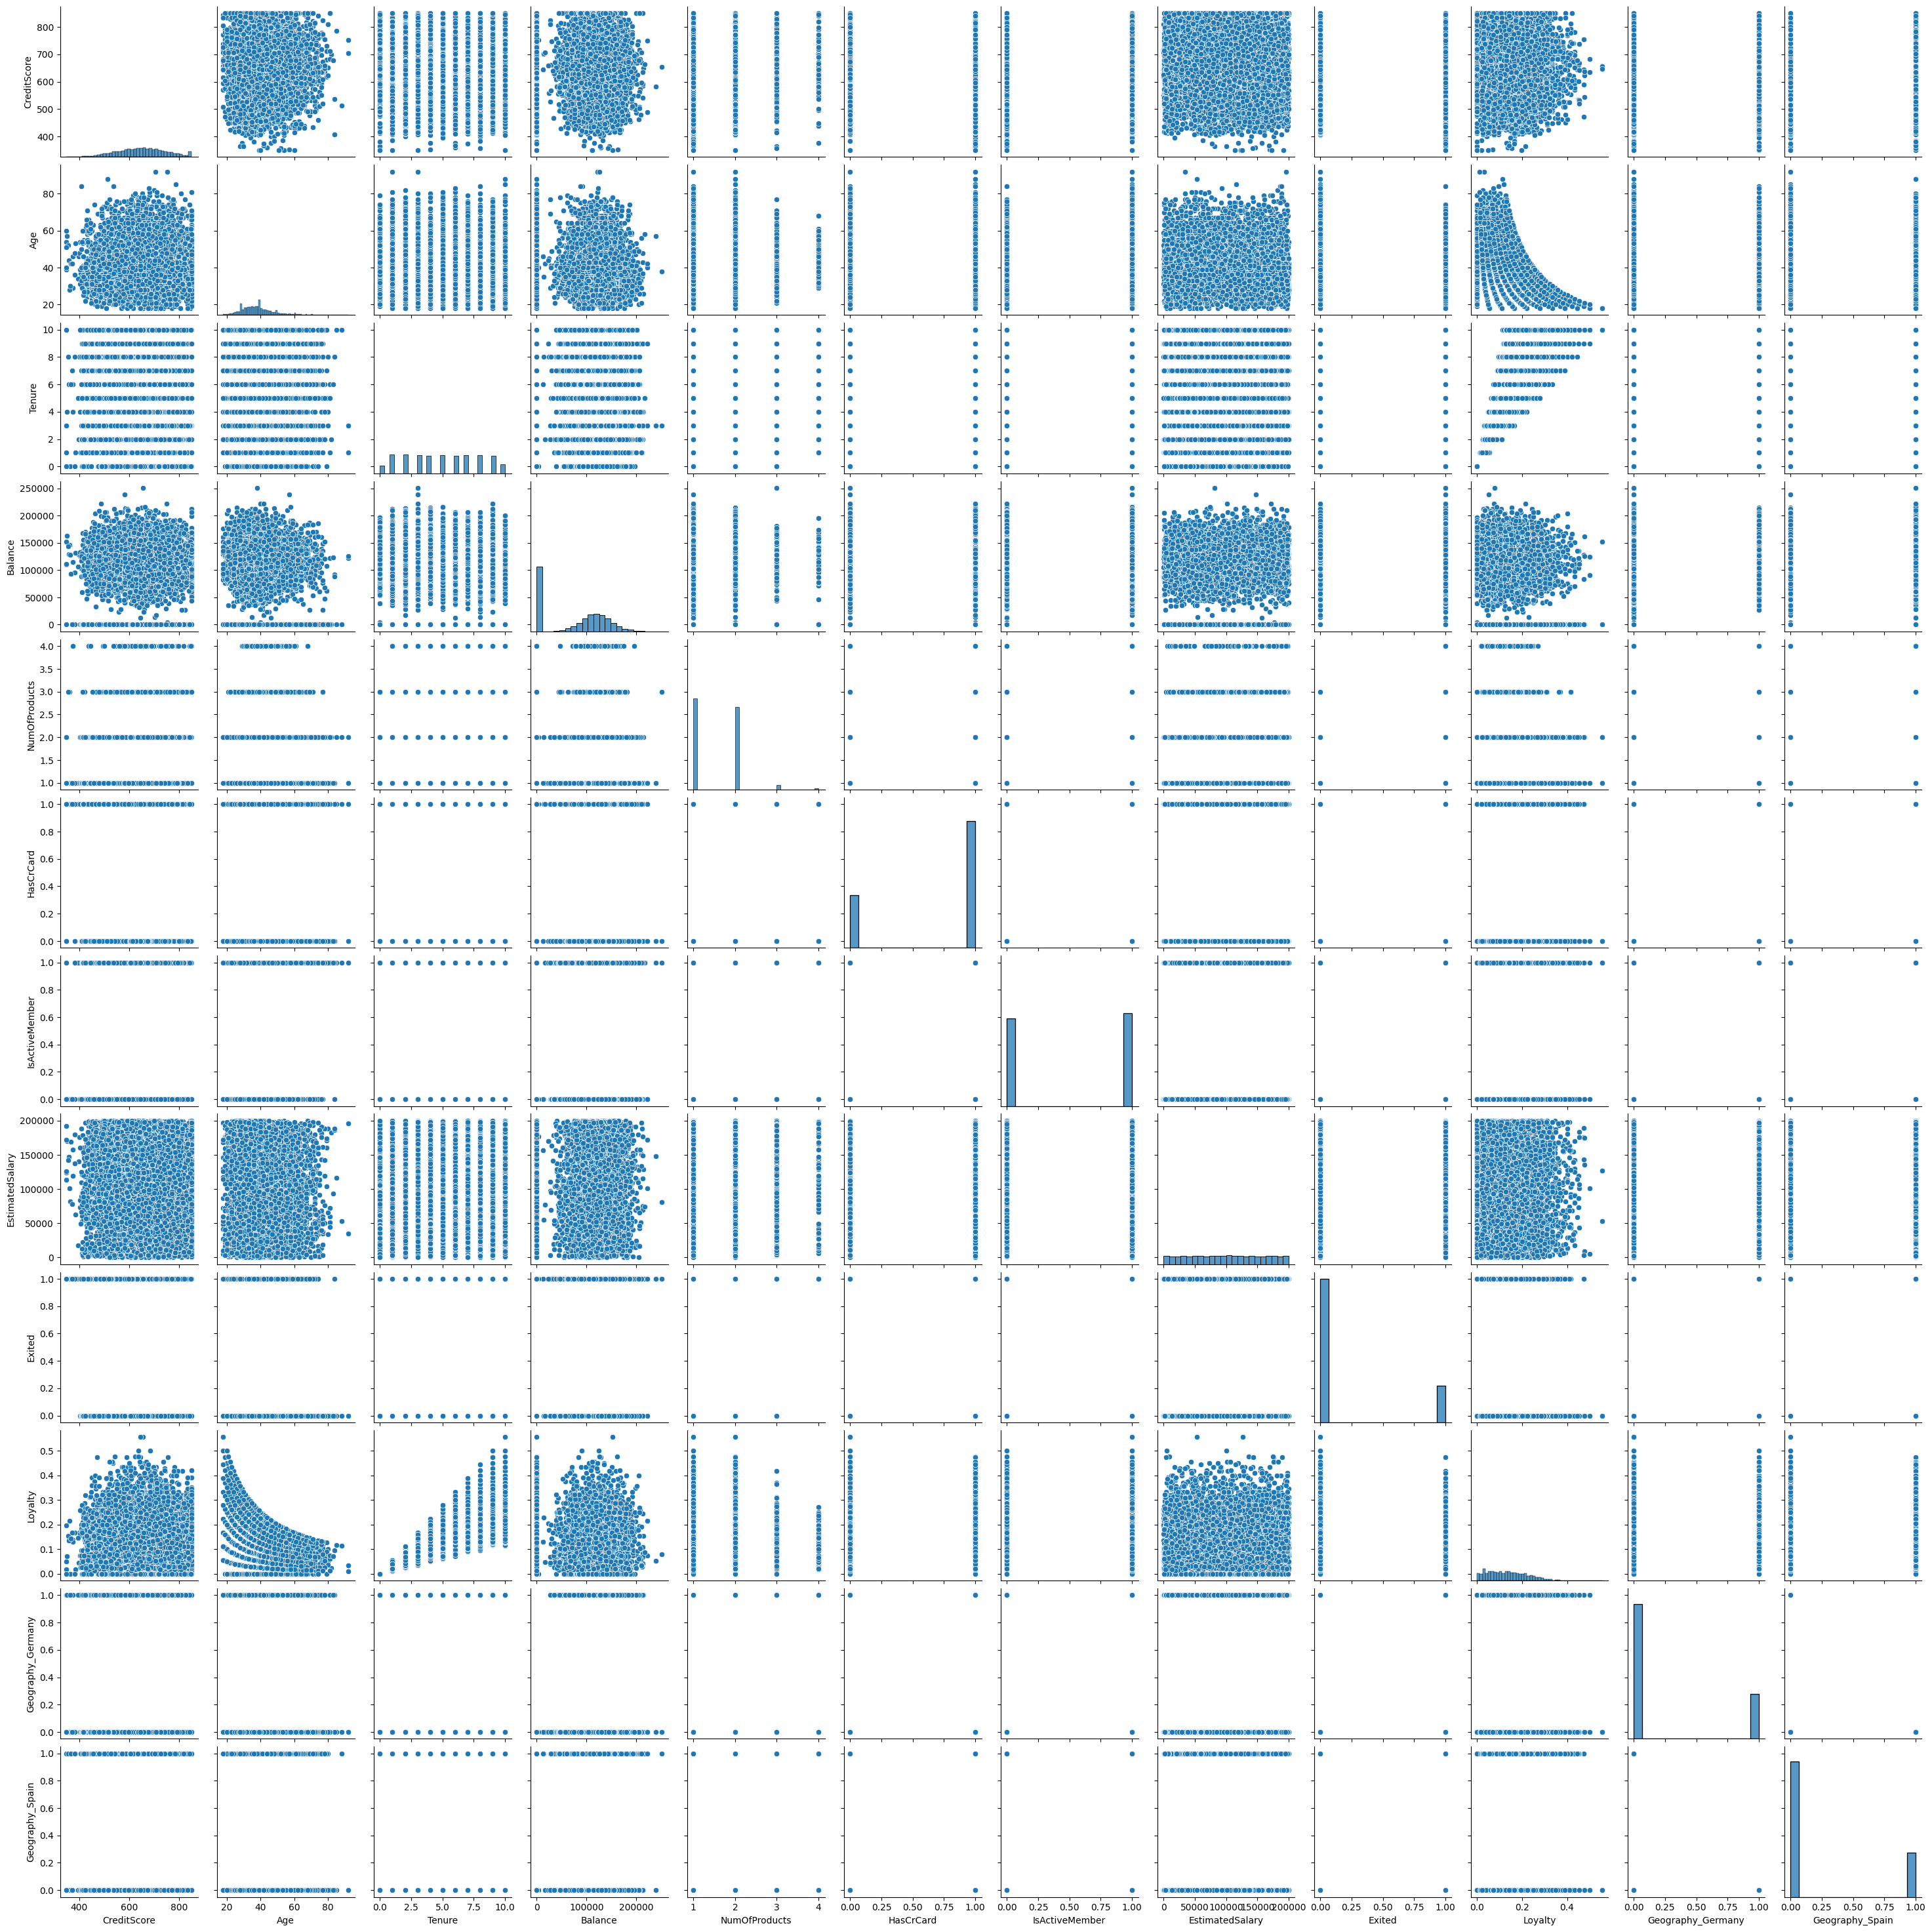

In [67]:
sns.pairplot(churn_df)

## Model Preparation

In [10]:
y = churn_df['Exited']
x = churn_df.copy()
x = x.drop(columns='Exited', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)

In [11]:
y.unique()
# A Binary classification model is more suitable here

array([1, 0])

In [12]:
x.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Loyalty,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,0.047619,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0.024390,False,True
2,502,42,8,159660.80,3,1,0,113931.57,0.190476,False,False
3,699,39,1,0.00,2,0,0,93826.63,0.025641,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0.046512,False,True


## Baseline Decision Tree Model

We'll first train a baseline model, just to get a sense of how predictive the data is and to give us scores that we can reference later. This will also show the process of instantiating and fitting the model, and then using it to make predictions. We'll predict on the test data.

In [77]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt

DecisionTreeClassifier(random_state=0)

#### Results and Evaluation

In [78]:
# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.802
Precision: 0.515
Recall: 0.511
F1 Score: 0.513


In [100]:
results = []
results.append({'Model': 'Decision Tree', 'Accuracy': accuracy_score(y_test, dt_pred),
              'Precision': precision_score(y_test, dt_pred), 'Recall': recall_score(y_test, dt_pred),
              'F1 Score': f1_score(y_test, dt_pred)})
results

[{'Model': 'Decision Tree',
  'Accuracy': 0.8024,
  'Precision': 0.5148514851485149,
  'Recall': 0.5108055009823183,
  'F1 Score': 0.5128205128205128}]

#### Analysis of the baseline model

In [22]:
def conf_matrix_plot(model, x_data, y_data):
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format='')
    plt.show()

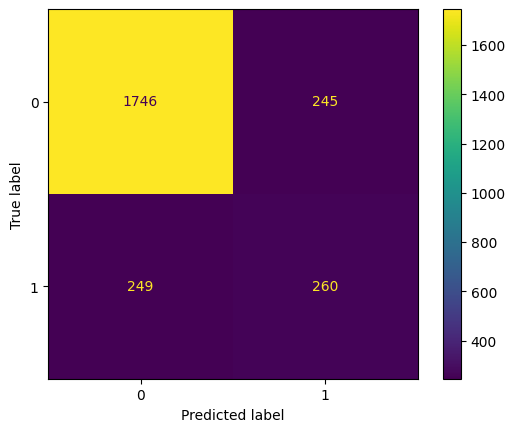

In [23]:
# Generate confusion matrix
conf_matrix_plot(dt, X_test, y_test)

Notice from this confusion matrix that the model correctly predicts many true negatives. Of course, this is to be expected, given that the dataset is imbalanced in favor of negatives. When the model makes an error, it appears slightly more likely to predict a false positive than a false negative, but it's generally balanced. This is reflected in the precision and recall scores both being very close to each other.

#### Plotting the tree

This plot represents how the tree grew from the training data. To make its predictions on the test data, the tree would simply pass each customer in the test data through its splits, from the root node all the way down to a leaf node.

In [30]:
print(list(x.columns))

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Loyalty', 'Geography_Germany', 'Geography_Spain']


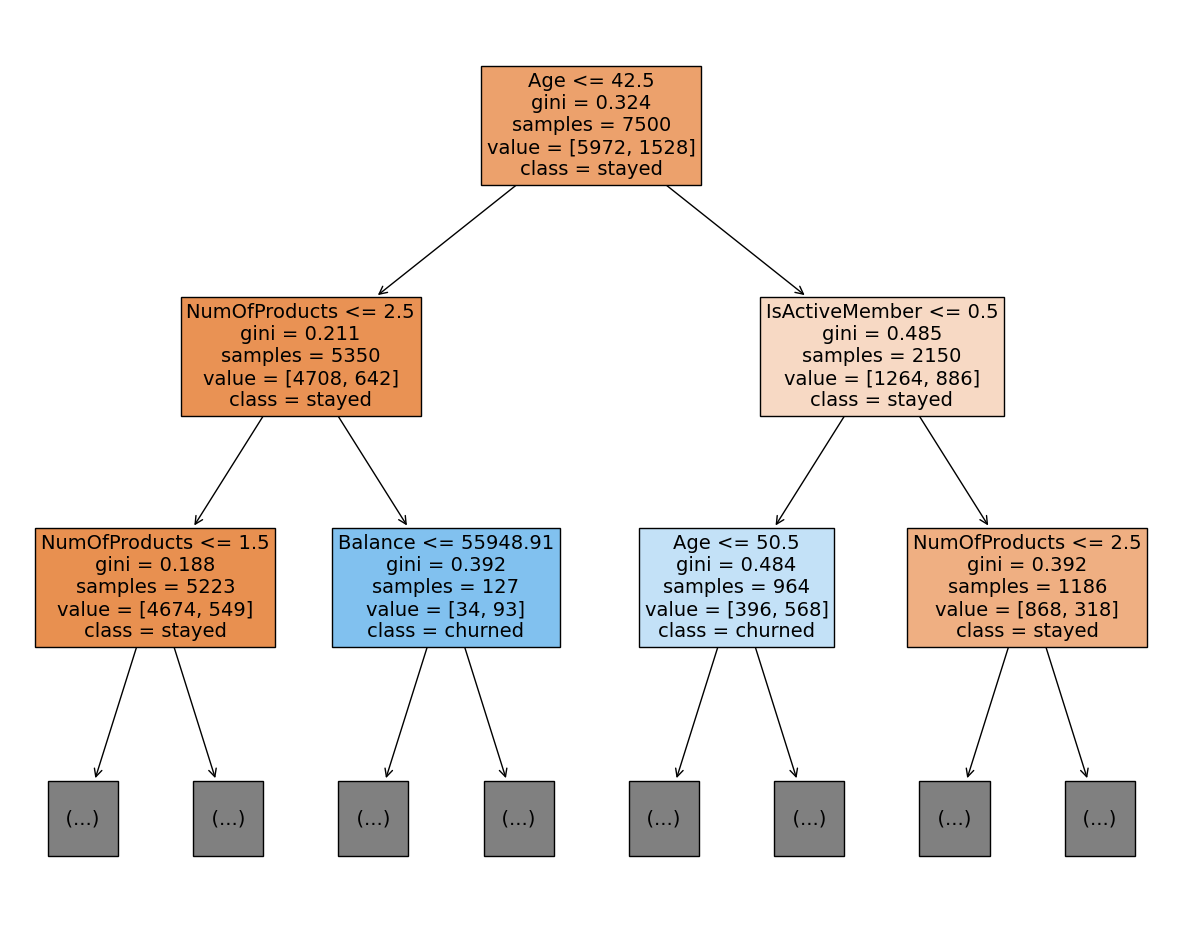

In [35]:
# Plot the tree
plt.figure(figsize=(15,12))
plot_tree(dt, max_depth=2, fontsize=14, feature_names = list(x.columns), class_names=['stayed', 'churned'], filled=True)
plt.show()

The first line of information in each node is the feature and split point that the model identified as being most predictive. In other words, this is the question that is being asked at that split. For our root node, the question was: _Is the customer less than or equal to 42.5 years old?_

At each node, if the answer to the question it asks is "yes," the sample would move to the child node on the left. If the answer is "no," the sample would go to the child node on the right.

`gini` refers to the node's _Gini impurity_. This is a way of measuring how "pure" a node is. The value can range from 0 to 0.5. A Gini score of 0 means there is no impurity&mdash;the node is a leaf, and all of its samples are of a single class. A score of 0.5 means the classes are all equally represented in that node.

`samples` is simply how many samples are in that node, and `value` indicates how many of each class are in the node. Returning to the root node, we have `value = [5972, 1528]`. Notice that these numbers sum to 7,500, which is the number of samples in the node. This tells us that 5,972 customers in this node stayed (y=0) and 1,528 customers churned (y=1).

Lastly, we have `class` that tells us the majority class of the samples in each node. 

The above plot tells us that, if we could only do a single split on a single variable, the one that would most help us predict whether a customer will churn is their age.

If we look at the nodes at depth one, we notice that the number of products and whether or not the customer is an active member also are both strong predictors (relative to the features we have) of whether or not they will churn.
Finally, it's worth noting that there is no single question that can be asked—for any feature—that would cause a majority of samples in one of the child nodes to be of class "churned." The tree must get to depth two (i.e., two questions must be asked) before this happens.

####  Cross-validated hyperparameter tuning


In [36]:
from sklearn.model_selection import GridSearchCV

In [39]:
tuned_dt = DecisionTreeClassifier(random_state = 42)
# Assign a dictionary of hyperparameters to search over
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}
# Assign a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [88]:
%%time
# Instantiate the GridSearch
clf = GridSearchCV(tuned_dt, tree_para, scoring = scoring, cv=5, refit="f1")
clf.fit(X_train, y_train)

CPU times: user 5.89 s, sys: 35.8 ms, total: 5.93 s
Wall time: 5.93 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'min_samples_leaf': [2, 5, 10, 20, 50]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [89]:
# Examine the best model from GridSearch 
clf.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=20, random_state=42)

In [90]:
print("Best Avg. Validation Score: ", "%.4f" % clf.best_score_)

Best Avg. Validation Score:  0.5613


In [101]:
def model_scores(model_name, model):
    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model.cv_results_)
    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]
    print("F1 score : ", best_estimator_results.mean_test_f1)
    print("Recall : ", best_estimator_results.mean_test_recall)
    print("Precision : ", best_estimator_results.mean_test_precision)
    print("Accuracy : ", best_estimator_results.mean_test_accuracy)
    
    results = {'Model': model_name, 'Accuracy': best_estimator_results.mean_test_accuracy,
              'Precision': best_estimator_results.mean_test_precision, 'Recall': best_estimator_results.mean_test_recall,
              'F1 Score': best_estimator_results.mean_test_f1}
    return results
    
res = model_scores('Tuned Decision Tree', clf)
results.append(res)
results

F1 score :  0.5613130808427034
Recall :  0.4529026036644166
Precision :  0.7423352021734433
Accuracy :  0.8561333333333334


[{'Model': 'Decision Tree',
  'Accuracy': 0.8024,
  'Precision': 0.5148514851485149,
  'Recall': 0.5108055009823183,
  'F1 Score': 0.5128205128205128},
 {'Model': 'Tuned Decision Tree',
  'Accuracy': 0.8561333333333334,
  'Precision': 0.7423352021734433,
  'Recall': 0.4529026036644166,
  'F1 Score': 0.5613130808427034}]

Although the F1 score of 0.561 is significantly better than the baseline model's F1 score of 0.513, it's not a fair comparison, because the baseline model was scored on the test data and the tuned model was scored against validation folds that came from the training data. 

These results show that our model's performance isn't great, but it's not terrible either. Maybe another kind of model will do better...

## Random Forest Classification Model

In [54]:
rf = RandomForestClassifier(random_state=0)
cv_params = {'max_depth': [2,3,4,5, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             } 

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

In [61]:
path = '/Users/sagarikasardesai/Downloads/Transfer/Portfolio/Learning Projects/'

In [ ]:
# # Read in pickled model
# with open(path + 'rf_cv_model.pickle', 'rb') as to_read:
#     rf_cv = pickle.load(to_read)

In [55]:
%%time
rf_cv.fit(X_train, y_train)
rf_cv.best_params_

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [56]:
rf_cv.best_score_

0.5813676103635199

Since this model took a long time to fit, we don’t want to have to fit them more than once. If our kernel disconnects or we shut down the notebook and lose the cell’s output, we’ll have to refit the model, which can be frustrating and time-consuming.

pickle is a tool that saves the fit model object to a specified location, then quickly reads it back in. It also allows us to use models that were fit somewhere else, without having to train them ourself.

In [62]:
with open(path+'rf_cv_model.pickle', 'wb') as to_write:
    pickle.dump(rf_cv, to_write)

The F1 score of 0.5814 is significantly better than the decision tree model's F1 score of 0.5613

In [102]:
res = model_scores('Random Forest', rf_cv)
results.append(res)
results

F1 score :  0.5813676103635199
Recall :  0.4744840887174542
Precision :  0.754305899688017
Accuracy :  0.8609333333333333


[{'Model': 'Decision Tree',
  'Accuracy': 0.8024,
  'Precision': 0.5148514851485149,
  'Recall': 0.5108055009823183,
  'F1 Score': 0.5128205128205128},
 {'Model': 'Tuned Decision Tree',
  'Accuracy': 0.8561333333333334,
  'Precision': 0.7423352021734433,
  'Recall': 0.4529026036644166,
  'F1 Score': 0.5613130808427034},
 {'Model': 'Random Forest',
  'Accuracy': 0.8609333333333333,
  'Precision': 0.754305899688017,
  'Recall': 0.4744840887174542,
  'F1 Score': 0.5813676103635199}]

### Hyperparameter tuning with Separate Validation Set

When we tune hyperparameters with GridSearchCV using a separate validation dataset, we have to take a few extra steps. GridSearchCV wants to cross-validate the data. In fact, if the cv argument were left blank, it would split the data into five folds for cross-validation by default.

We don't want it to do this. Instead, we're going to tell it exactly which rows of X_train are for training, and which rows are for validation. To do this, we need to make a list of length len(X_train) where each element is either a 0 or -1. A 0 in index i will indicate to GridSearchCV that index i of X_train is to be held out for validation. A -1 at a given index will indicate that that index of X_train is to be used as training data.

We'll make this list using a list comprehension that looks at the index number of each row in X_train. If that index number is in X_val's list of index numbers, then the list comprehension appends a 0. If it's not, then it appends a -1.

In [70]:
# Create separate validation data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                            stratify=y_train, random_state=10)
# Create list of split indices
split_index = [0 if x in X_val.index else -1 for x in X_train.index]

In [71]:
from sklearn.model_selection import PredefinedSplit

rf = RandomForestClassifier(random_state=0)
cv_params = {'max_depth': [2,3,4,5, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }  
custom_split = PredefinedSplit(split_index)
rf_val = GridSearchCV(rf, cv_params, scoring=scoring, cv=custom_split, refit='f1')

In [ ]:
# # Open pickled model
# with open(path+'rf_val_model.pickle', 'rb') as to_read:
#     rf_val = pickle.load(to_read)

In [73]:
%%time
rf_val.fit(X_train, y_train)

CPU times: user 2min 21s, sys: 2.26 s, total: 2min 23s
Wall time: 2min 23s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1,  0, ..., -1, -1])),
             estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

This will take less time than when we cross-validated—about 1/5 of the time. This is because during cross-validation the training data was divided into five folds. An ensemble of trees was grown with a particular combination of hyperparameters on four folds of data, and validated on the fifth fold that was held out. This whole process happened for each of five holdout folds. Then, another ensemble was trained with the next combination of hyperparameters, repeating the whole process. This continued until there were no more combinations of hyperparameters to run.

But now that we're using a separate validation set, an ensemble is built for each combination of hyperparameters. Each ensemble is trained on the new training set and validated on the validation set. But this only happens one time for each combination of hyperparameters, instead of five times with cross-validation. That’s why the training time was only a fifth as long.

In [74]:
# Pickle the model
with open(path+'rf_val_model.pickle', 'wb') as to_write:
    pickle.dump(rf_val, to_write)

In [75]:
rf_val.best_params_

{'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 75}

In [103]:
res = model_scores('Random Forest 2', rf_val)
results.append(res)
results

F1 score :  0.5803757828810021
Recall :  0.4542483660130719
Precision :  0.8034682080924855
Accuracy :  0.866


[{'Model': 'Decision Tree',
  'Accuracy': 0.8024,
  'Precision': 0.5148514851485149,
  'Recall': 0.5108055009823183,
  'F1 Score': 0.5128205128205128},
 {'Model': 'Tuned Decision Tree',
  'Accuracy': 0.8561333333333334,
  'Precision': 0.7423352021734433,
  'Recall': 0.4529026036644166,
  'F1 Score': 0.5613130808427034},
 {'Model': 'Random Forest',
  'Accuracy': 0.8609333333333333,
  'Precision': 0.754305899688017,
  'Recall': 0.4744840887174542,
  'F1 Score': 0.5813676103635199},
 {'Model': 'Random Forest 2',
  'Accuracy': 0.866,
  'Precision': 0.8034682080924855,
  'Recall': 0.4542483660130719,
  'F1 Score': 0.5803757828810021}]

## XGBoost

In [106]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import RocCurveDisplay

The cross-validation process is the same as it was for the decision tree and random forest models. The only difference is that we're tuning different hyperparameters now. 

1. Instantiate the classifier (and set the `random_state`). Note here that we've included a parameter called `objective` whose value is `binary:logistic`. This means that the model is performing a binary classification task that outputs a logistic probability. The objective would be different for different kinds of problems—for instance, if we were trying to predict more than two classes or performing a linear regression on continuous data.

2. Create a dictionary of hyperparameters to search over.

3. Instantiate the `GridSearchCV` object. Pass as arguments:
  - The classifier (`xgb`)
  - The dictionary of hyperparameters to search over (`cv_params`)
  - The dictionary of scoring metrics (`scoring`)
  - The number of cross-validation folds we want (`cv=5`)
  - The scoring metric that we want GridSearch to use when it selects the "best" model (i.e., the model that performs best on average over all validation folds) (`refit='f1'`)

4. Fit the data (`X_train`, `y_train`) to the `GridSearchCV` object (`xgb_cv`)

In [107]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0) 
cv_params = {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
             }    
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [ ]:
# # Open pickled model
# with open(path+'xgb_cv_model.pickle', 'rb') as to_read:
#     xgb_cv = pickle.load(to_read)

In [108]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 19min 23s, sys: 6min 24s, total: 25min 47s
Wall time: 3min 21s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [109]:
# Pickle the model
with open(path + 'xgb_cv_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write) 

In [110]:
xgb_cv.best_score_

0.5873705926691309

In [111]:
res = model_scores('XGBoost CV', xgb_cv)
results.append(res)
results

F1 score :  0.5873705926691309
Recall :  0.5000085717347048
Precision :  0.7145054588560271
Accuracy :  0.8572


[{'Model': 'Decision Tree',
  'Accuracy': 0.8024,
  'Precision': 0.5148514851485149,
  'Recall': 0.5108055009823183,
  'F1 Score': 0.5128205128205128},
 {'Model': 'Tuned Decision Tree',
  'Accuracy': 0.8561333333333334,
  'Precision': 0.7423352021734433,
  'Recall': 0.4529026036644166,
  'F1 Score': 0.5613130808427034},
 {'Model': 'Random Forest',
  'Accuracy': 0.8609333333333333,
  'Precision': 0.754305899688017,
  'Recall': 0.4744840887174542,
  'F1 Score': 0.5813676103635199},
 {'Model': 'Random Forest 2',
  'Accuracy': 0.866,
  'Precision': 0.8034682080924855,
  'Recall': 0.4542483660130719,
  'F1 Score': 0.5803757828810021},
 {'Model': 'XGBoost CV',
  'Accuracy': 0.8572,
  'Precision': 0.7145054588560271,
  'Recall': 0.5000085717347048,
  'F1 Score': 0.5873705926691309}]

## Model Selection and Final Results

In [112]:
resultsdf = pd.DataFrame.from_dict(results)
resultsdf = resultsdf.sort_values(by=['F1 Score'], ascending=False)
resultsdf

,Model,Accuracy,Precision,Recall,F1 Score
4,XGBoost CV,0.857200,0.714505,0.500009,0.587371
2,Random Forest,0.860933,0.754306,0.474484,0.581368
3,Random Forest 2,0.866000,0.803468,0.454248,0.580376
1,Tuned Decision Tree,0.856133,0.742335,0.452903,0.561313
0,Decision Tree,0.802400,0.514851,0.510806,0.512821


The results in the table above tell us that the cross-validated random forest model performs a little better than the one trained on a separate validation set. It performs well for precision and accuracy, but the recall is 0.4542. This means that out of all the people in the validation folds who actually left the bank, the model successfully identifies 45.42% of them.

Based on the above table, it's clear that our XGBoost model has the top F1 score on the validation data by a small margin.

In [113]:
# Predict on test data
xgb_cv_preds = xgb_cv.predict(X_test)
print('F1 score final XGB model: ', f1_score(y_test, xgb_cv_preds))
print('Recall score final XGB model: ', recall_score(y_test, xgb_cv_preds))
print('Precision score final XGB model: ', precision_score(y_test, xgb_cv_preds))
print('Accuracy score final XGB model: ', accuracy_score(y_test, xgb_cv_preds))

F1 score final XGB model:  0.5920745920745921
Recall score final XGB model:  0.49901768172888017
Precision score final XGB model:  0.7277936962750716
Accuracy score final XGB model:  0.86


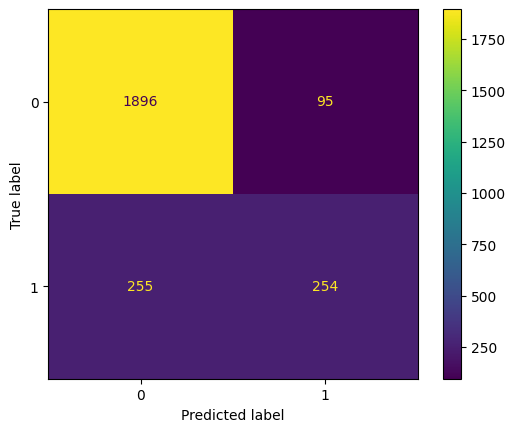

In [114]:
conf_matrix_plot(xgb_cv, X_test, y_test)

From the 2,500 people in our test data, there are 509 customers who left the bank. Of those, our model captures 256. The confusion matrix indicates that, when the model makes an error, it’s usually a Type II error—it gives a false negative by failing to predict that a customer will leave. On the other hand, it makes far fewer Type I errors, which are false positives.

Ultimately, whether these results are acceptable depends on the costs of the measures taken to prevent a customer from leaving versus the value of retaining them. In this case, bank leaders may decide that they’d rather have more true positives, even if it means also capturing significantly more false positives. If so, perhaps optimizing the models based on their F1 scores is insufficient. Maybe we’d prioritize a different evaluation metric.

One way to modify the decision-making without retraining the model is to adjust the threshold at which the model predicts a positive response. In other words, the model determines a probability that a given customer will churn. By default, if that probability is ≥ 0.50, then the model will label that customer as churned. Probabilities of < 0.50 would designate a non-responder. But it's possible to adjust this decision threshold. For instance, if we set the threshold to 0.25, then the model would label customers with predicted probabilities ≥ 0.25 as churned, and those with probabilities < 0.25 as not churned. This would increase the recall of the model, but decrease the accuracy.

In any case, what is certain is that our model helps the bank. Consider the results if decision-makers had done nothing. In that case, they’d expect to lose 509 customers. Alternatively, they could give everybody an incentive to stay. That would cost the bank for each of the 2,500 customers in our test set. Finally, the bank could give incentives at random—say, by flipping a coin. Doing this would incentivize about the same number of true responders as our model selects. But the bank would lose a lot of money offering the incentives to people who aren’t likely to leave, and our model is very good at identifying these customers.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

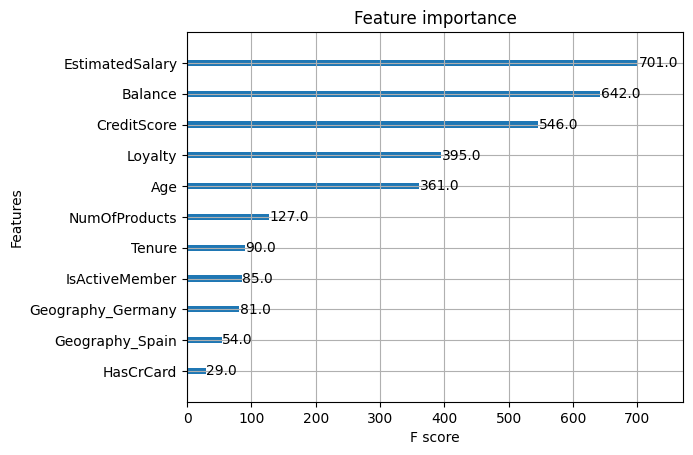

In [115]:
# The features selected by the model as the most predictive
plot_importance(xgb_cv.best_estimator_)

This tells us that the five most important features used by our model were `EstimatedSalary`, `Balance`, `CreditScore`, `Loyalty` and `Age`. 